In [97]:
# codigo de la url: https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm#scrollTo=VBXq-Wb_K1XR

In [98]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [99]:
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1577836800000,7195.24,7245.00,7175.46,7224.21,3646.232354,1577858399999,2.631450e+07,44901,1987.278850,1.434351e+07,0
1,1577858400000,7224.24,7237.73,7180.00,7197.20,4415.466238,1577879999999,3.182890e+07,51073,2173.642319,1.566963e+07,0
2,1577880000000,7197.20,7255.00,7196.15,7236.83,5443.680806,1577901599999,3.934948e+07,55857,3229.260535,2.334553e+07,0
3,1577901600000,7237.02,7246.72,7175.15,7200.85,3287.008767,1577923199999,2.372158e+07,42179,1556.773831,1.123912e+07,0
4,1577923200000,7200.77,7212.50,7116.70,7138.93,5561.311699,1577944799999,3.980317e+07,60466,2579.989270,1.846858e+07,0


In [100]:
# Change the time unit of the "open_time" and "close_time" columns
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

In [101]:
df.shape

(4984, 11)

Text(0, 0.5, 'Close Price (USD)')

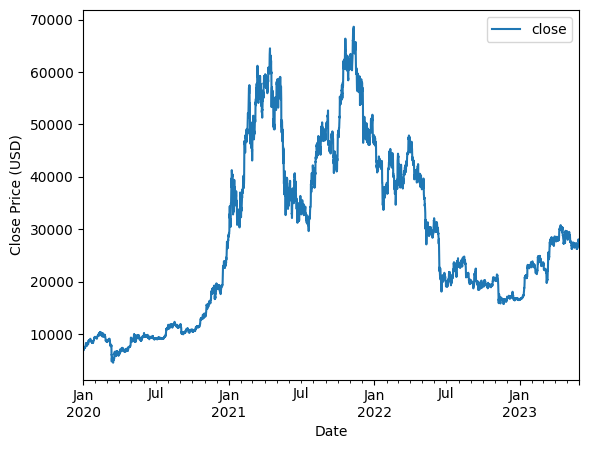

In [102]:
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [103]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [104]:
scaled_close.shape

(4984, 1)

In [105]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [106]:


class Preprocessor:
    def __init__(self, SEQ_LEN=100):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data, seq_len):
        d = []

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])

        return np.array(d)

    def preprocess(self, data_raw, train_split):

        data = self.to_sequences(data_raw, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]

        return X_train, y_train, X_test, y_test

preprocessor=Preprocessor()
X_train, y_train, X_test, y_test = preprocessor.preprocess(scaled_close, train_split = 0.80)

In [107]:
df.shape[0]-preprocessor.num_train

1077

In [108]:
X_train.shape

(3907, 99, 1)

In [109]:
X_test.shape

(977, 99, 1)

# Model

In [110]:
from tensorflow.keras.layers import LSTM

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1

model = keras.Sequential()

model.add(LSTM(WINDOW_SIZE, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1])),
                        )
model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE * 2, return_sequences=True))
model.add(Dropout(rate=DROPOUT))

model.add(LSTM(WINDOW_SIZE, return_sequences=False))

model.add(Dense(units=1))

model.add(Activation('linear'))


# Training

In [111]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer='adam'
)

In [112]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=6, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1,
    callbacks=[es]
)

Epoch 1/6
55/55 [==============================] - 58s 807ms/step - loss: 0.0054 - mae: 0.0584 - val_loss: 0.0087 - val_mae: 0.0918
Epoch 2/6
55/55 [==============================] - 41s 750ms/step - loss: 0.0264 - mae: 0.1209 - val_loss: 0.0242 - val_mae: 0.1542
Epoch 3/6
55/55 [==============================] - 41s 744ms/step - loss: 0.0473 - mae: 0.1666 - val_loss: 0.0036 - val_mae: 0.0580
Epoch 4/6
55/55 [==============================] - 41s 753ms/step - loss: 0.0205 - mae: 0.1090 - val_loss: 0.0076 - val_mae: 0.0863
Epoch 5/6
55/55 [==============================] - 43s 782ms/step - loss: 0.0103 - mae: 0.0830 - val_loss: 0.0021 - val_mae: 0.0442
Epoch 6/6
55/55 [==============================] - 43s 777ms/step - loss: 0.0054 - mae: 0.0558 - val_loss: 5.3228e-04 - val_mae: 0.0209


In [113]:
MAE=scaler.inverse_transform([[model.evaluate(X_test, y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

31/31 [==============================] - 5s 156ms/step - loss: 4.1277e-04 - mae: 0.0186
MAE for the test set: 5755.308979321048


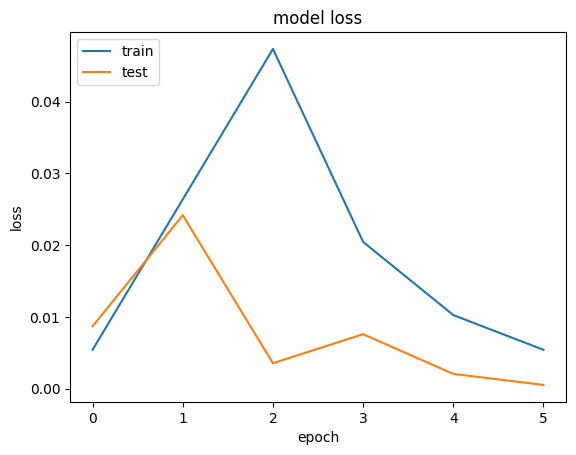

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [115]:
y_test.shape

(977, 1)

In [116]:

date_time_test=df.iloc[preprocessor.num_train+preprocessor.SEQ_LEN:,0].to_numpy()
date_time_test.shape

(977,)

31/31 [==============================] - 7s 174ms/step


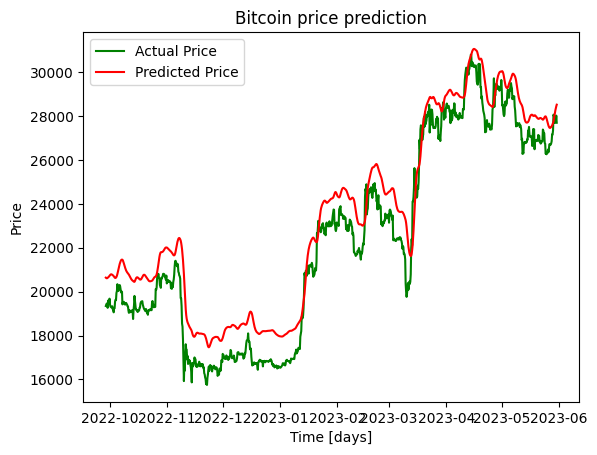

In [117]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

date_time_test=df.iloc[preprocessor.num_train+preprocessor.SEQ_LEN:,0].to_numpy()
 
plt.plot(date_time_test,y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test,y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

31/31 [==============================] - 5s 165ms/step


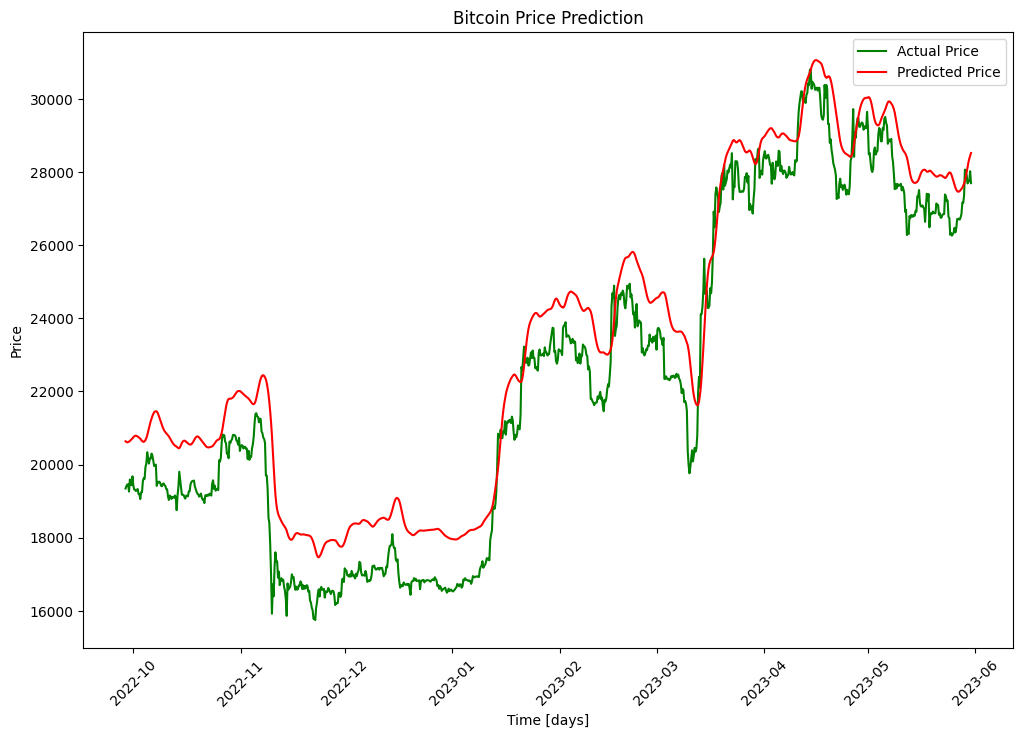

: 

In [118]:
# Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

date_time_test = df.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()
